# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* Offers sent during 30-day test period (10 offers x 6 fields)
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum money required spend to complete an offer
* reward (int) - reward given for completing an offer (money awarded for the amount spent)
* duration (int) - time for offer to be open, in days
* channels (list of strings) (web, email, mobile, social)

**profile.json**
* Rewards program users (17000 users x 5 fields)
* age (int) - age of the customer (missing value encoded as 118)
* became_member_on (int) - date when customer created an app account (format YYYYMMDD)
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* Event log (306648 events x 4 fields)
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record
* offer id: (string/hash) not associated with any "transaction"
* amount: (numeric) money spent in "transaction"
* reward: (numeric) money gained from "offer completed"


**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)                            

# Exploratory Data Analysis

## Transcript Datatframe

In [2]:
print(transcript.head())   
print(transcript.shape)
print(transcript.info())

                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
(306534, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3

No missing values in any of the columns. 

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64


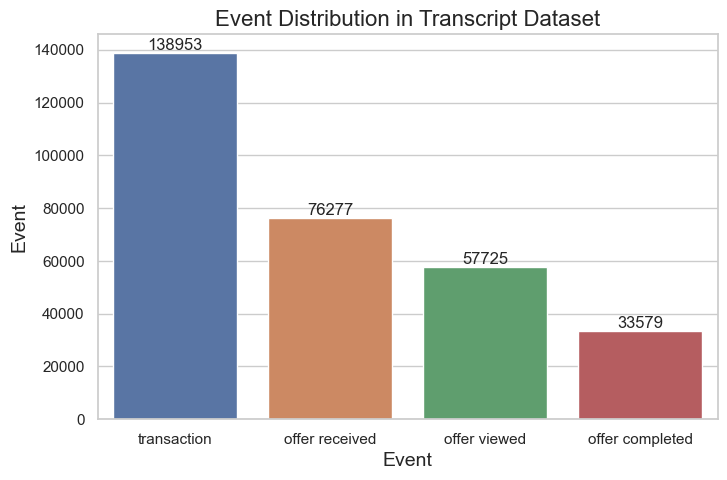

In [3]:
# Examining the distributions of 'events'
event_counts = transcript['event'].value_counts()
print(event_counts)

# Bar plot of 'event'  in the 'transcript' dataset
sns.set(style = 'whitegrid')

# Create a bar plot 
plt.figure(figsize= (8,5))
ax = sns.barplot(x = event_counts.index, y = event_counts.values, hue = event_counts.index)

# Titles and labels
plt.title('Event Distribution in Transcript Dataset', fontsize = 16)
plt.xlabel('Event', fontsize = 14)
plt.ylabel('Event', fontsize =14)

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64


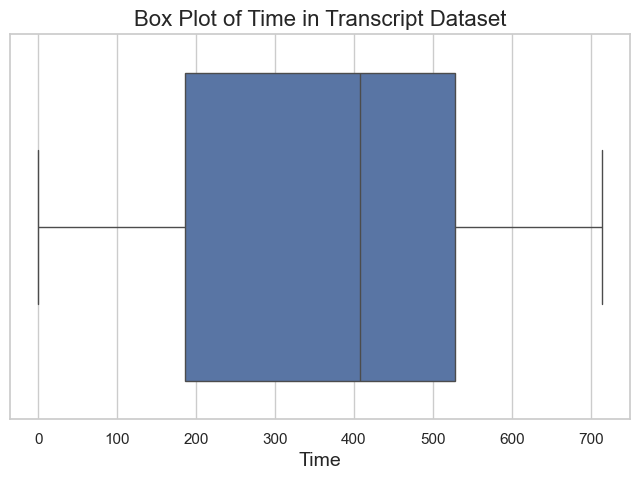

In [4]:
# Examining the 'time'
print(transcript['time'].describe())

# Box Plot of  'age' column

# Set the aesthetic style
sns.set(style='whitegrid')

# Create a box plot for 'age'
plt.figure(figsize = (8, 5))
sns.boxplot(x = transcript['time'])

# Titles and labels
plt.title('Box Plot of Time in Transcript Dataset', fontsize=16)
plt.xlabel('Time', fontsize = 14)

# Show the plot
plt.show()

In [5]:
# Examining the 'value' column
val_count = transcript['value'].value_counts()
print(val_count)

value
{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 42.31}                                       1
{'amount': 44.62}                                       1
{'amount': 42.27}                                       1
{'amount': 108.89}                                      1
{'amount': 476.33}                                      1
Name: count, Length: 5121, dtype: int64


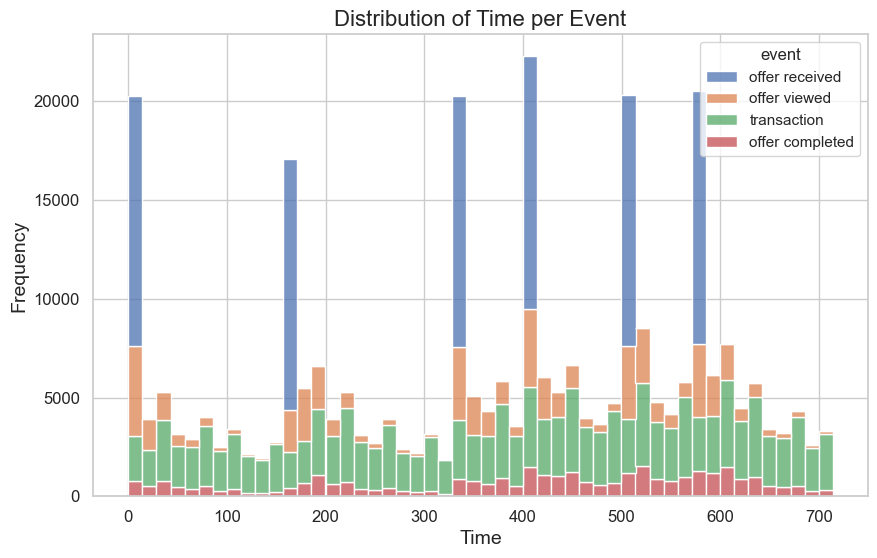

In [6]:
# Histogram for each event type and time

# Set style for seaborn plots
sns.set(style="whitegrid")

# Plot histogram for each event type
plt.figure(figsize=(10, 6))
sns.histplot(data=transcript, x='time', hue='event', multiple='stack', bins=50, legend = True)
plt.title('Distribution of Time per Event', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(title='Event', fontsize=12)
plt.show()


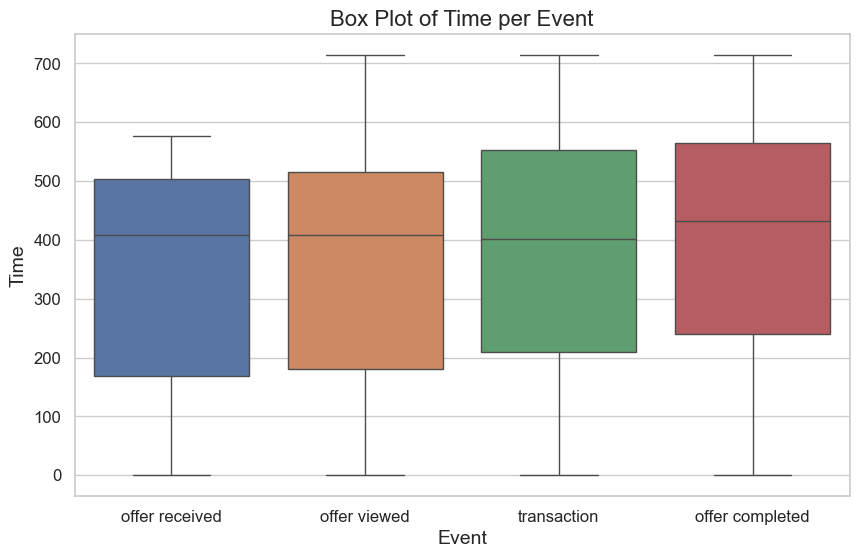

In [7]:
# Box plot for time distribution per event
plt.figure(figsize=(10, 6))
sns.boxplot(data=transcript, x='event', y='time', hue = 'event')

# Add titles and labels
plt.title('Box Plot of Time per Event', fontsize=16)
plt.xlabel('Event', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


## Portfolio Dataframe

In [8]:
print(portfolio.head(10))
print(portfolio.shape)

   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f

In [9]:
print(portfolio.describe())

          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000


## Profile Dataframe

In [10]:
print(profile.head())

  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [12]:
# Get the number of null values in 'profile' dataset
print(profile.isnull().sum())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


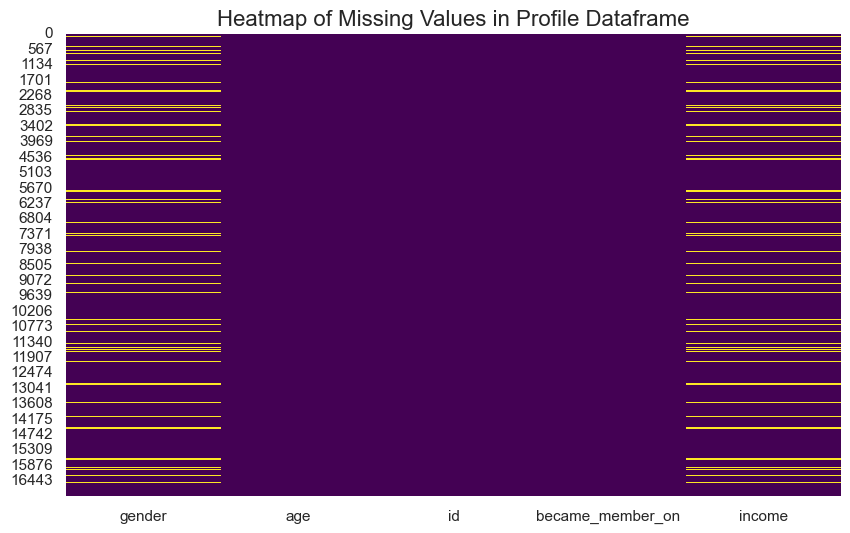

In [13]:
# Create a heatmap to visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(profile.isnull(), cbar=False, cmap='viridis')

# Add a title
plt.title('Heatmap of Missing Values in Profile Dataframe', fontsize=16)

# Show the plot
plt.show()


In [14]:
# Count the occurences of each gender
gender_counts = profile['gender'].value_counts()
index = ['Male', 'Female', 'Other']
gender_counts.index = index
print(gender_counts)

Male      8484
Female    6129
Other      212
Name: count, dtype: int64


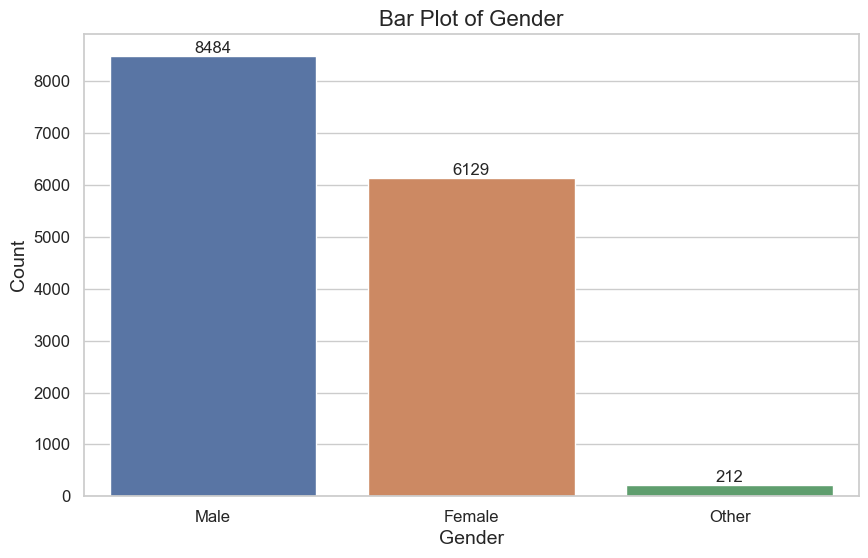

In [15]:
# Bar Plot for 'gender'ArithmeticError
plt.figure(figsize = (10, 6))
ax = sns.barplot( x = gender_counts.index, y = gender_counts.values, hue = gender_counts.index)

# Add titles and labels
plt.title('Bar Plot of Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the count labels directly on top of the bars
for i in ax.containers:
    ax.bar_label(i,) 


plt.show()

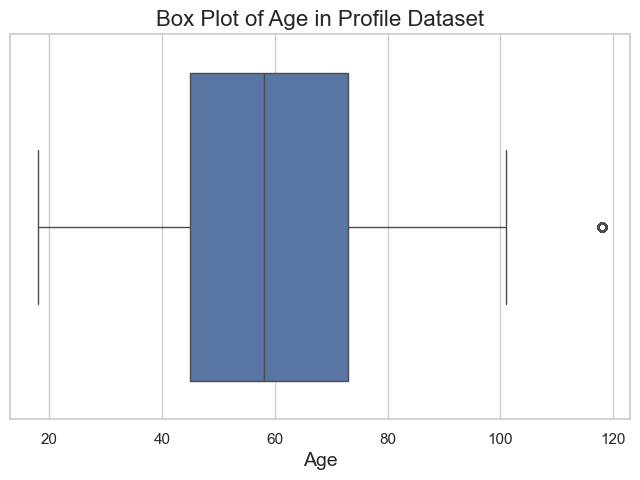

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [16]:
# Box Plot of  'age' column

# Set the aesthetic style
sns.set(style='whitegrid')

# Create a box plot for 'age'
plt.figure(figsize = (8, 5))
sns.boxplot(x = profile['age'])

# Titles and labels
plt.title('Box Plot of Age in Profile Dataset', fontsize=16)
plt.xlabel('Age', fontsize = 14)

# Show the plot
plt.show()

profile['age'].describe()

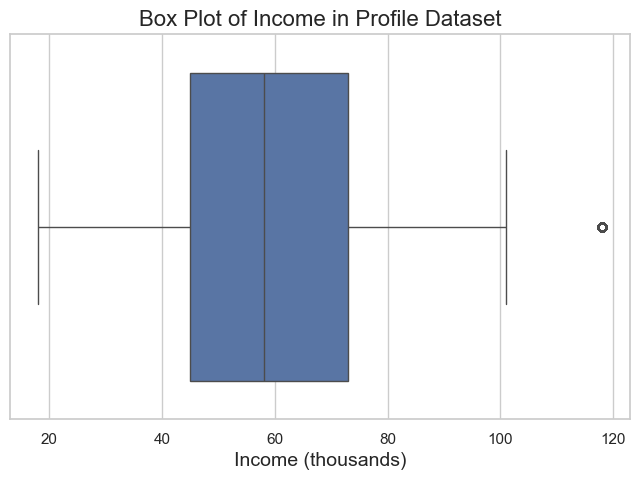

In [17]:
# Box Plot of  'income' column

# Set the aesthetic style
sns.set(style='whitegrid')

# Create a box plot for 'age'
plt.figure(figsize = (8, 5))
sns.boxplot(x = profile['age'])

# Titles and labels
plt.title('Box Plot of Income in Profile Dataset', fontsize=16)
plt.xlabel('Income (thousands)', fontsize = 14)

# Show the plot
plt.show()


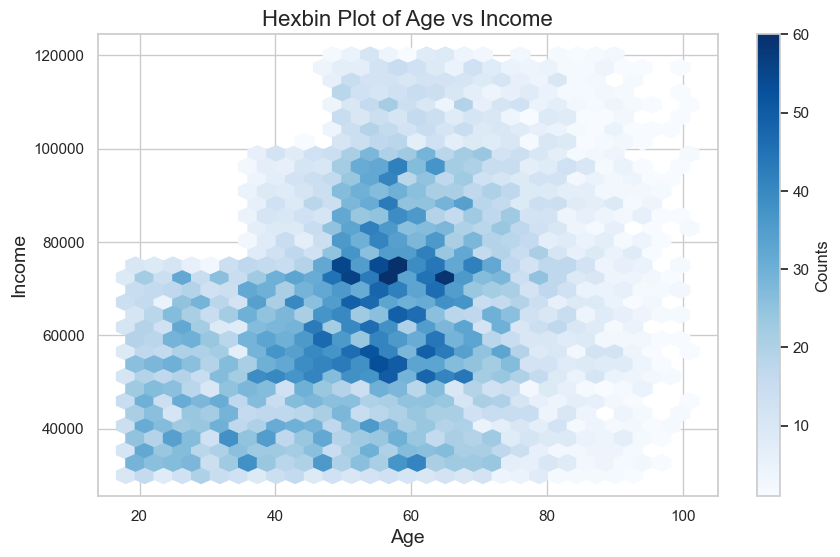

In [18]:
# Scatter plot: Relationship between Age and Income

plt.figure(figsize=(10, 6))

# Create the hexbin plot
plt.hexbin(profile['age'], profile['income'], gridsize=30, cmap='Blues', mincnt=1)

# Add titles and labels
plt.title('Hexbin Plot of Age vs Income', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Income', fontsize=14)

# Add color bar to show density scale
plt.colorbar(label='Counts')

plt.show()



C:\Users\cerde\AppData\Local\Temp\ipykernel_33536\136840926.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=profile['age_cat'], y=profile['income'], palette='muted')


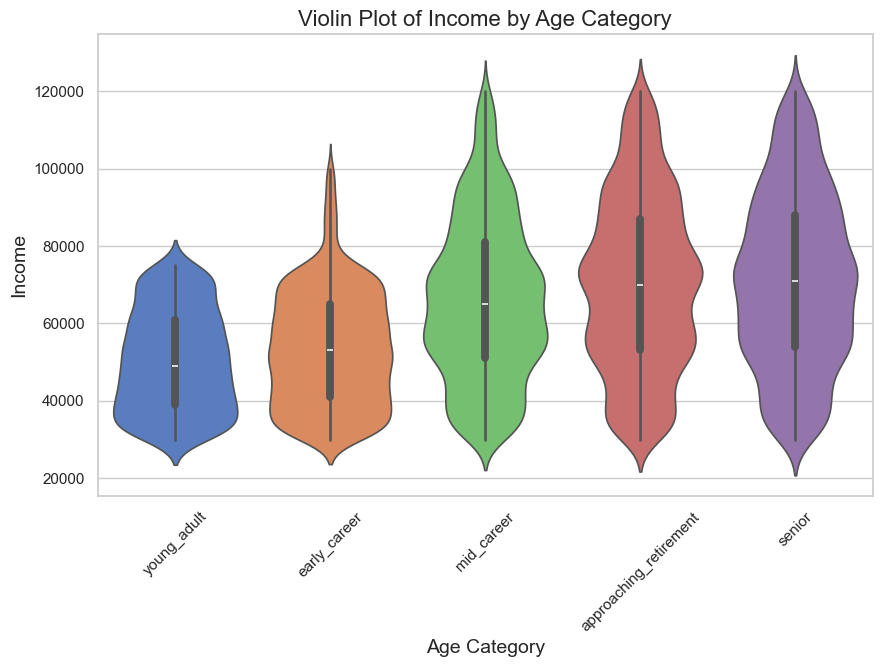

In [19]:
# Violin graphs

# Define the age bins and corresponding labels
bins = [17, 25, 40, 55, 70, float('inf')]
labels = ['young_adult', 'early_career', 'mid_career', 'approaching_retirement', 'senior']

# Create the 'age_cat' column using pd.cut
profile['age_cat'] = pd.cut(profile['age'], bins=bins, labels=labels, right=True)

plt.figure(figsize=(10, 6))

# Create the violin plot
sns.violinplot(x=profile['age_cat'], y=profile['income'], palette='muted')

# Add titles and labels
plt.title('Violin Plot of Income by Age Category', fontsize=16)
plt.xlabel('Age Category', fontsize=14)
plt.ylabel('Income', fontsize=14)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


# Preprocessing & Feauture Engineering

## Transcript dataset

In [84]:
print(transcript.head())

                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

                           offer_id  amount  reward  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN     NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN     NaN  
2  2906b810c7d4411798c6938adc9daaa5     NaN     NaN  
3  fafdcd668e3743c1bb461111dcafc2a4     NaN     NaN  
4  4d5c57ea9a6940dd891ad53e9dbe8

In [21]:
# Create an offer_id column
def extract_offer_id(column):
    # Check if column is a dictionary and contains the relevant keys
    if isinstance(column, dict):
        # Handle case with 'offer id' (with a space)
        if 'offer id' in column:
            return column.get('offer id', np.nan)
        # Handle case with 'offer_id' (with an underscore)
        elif 'offer_id' in column:
            return column.get('offer_id', np.nan)
    # Return NaN if none of the conditions are met (e.g., for transaction events)
    return np.nan


In [22]:
transcript['offer_id'] = transcript['value'].apply(extract_offer_id)

print(transcript['offer_id'].head())
print(transcript['offer_id'].value_counts())
print(transcript['offer_id'].isnull().sum())

0    9b98b8c7a33c4b65b9aebfe6a799e6d9
1    0b1e1539f2cc45b7b9fa7c272da2e1d7
2    2906b810c7d4411798c6938adc9daaa5
3    fafdcd668e3743c1bb461111dcafc2a4
4    4d5c57ea9a6940dd891ad53e9dbe8da0
Name: offer_id, dtype: object
offer_id
fafdcd668e3743c1bb461111dcafc2a4    20241
2298d6c36e964ae4a3e7e9706d1fb8c2    20139
f19421c1d4aa40978ebb69ca19b0e20d    19131
4d5c57ea9a6940dd891ad53e9dbe8da0    18222
ae264e3637204a6fb9bb56bc8210ddfd    18062
9b98b8c7a33c4b65b9aebfe6a799e6d9    16202
2906b810c7d4411798c6938adc9daaa5    15767
5a8bc65990b245e5a138643cd4eb9837    14305
0b1e1539f2cc45b7b9fa7c272da2e1d7    13751
3f207df678b143eea3cee63160fa8bed    11761
Name: count, dtype: int64
138953


In [23]:
# Create an 'amount' column

def extract_amount(column):
        # Check if column is a dictionary and contains the relevant keys
    if isinstance(column, dict):
        # Handle case with 'offer id' (with a space)
        if 'amount' in column:
            return column.get('amount', np.nan)
    # Return NaN if the condition is not met
    return np.nan

transcript['amount'] = transcript['value'].apply(extract_amount)

print(transcript['amount'].head())
print(transcript['amount'].value_counts())
print(transcript['amount'].isnull().sum())

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: amount, dtype: float64
amount
0.05      431
0.66      166
1.18      165
1.01      163
1.23      161
         ... 
42.31       1
44.62       1
42.27       1
108.89      1
476.33      1
Name: count, Length: 5103, dtype: int64
167581


In [24]:
# Create a 'reward' column

def extract_reward(column):
        # Check if column is a dictionary and contains the relevant keys
    if isinstance(column, dict):
        # Handle case with 'offer id' (with a space)
        if 'reward' in column:
            return column.get('reward', np.nan)
    # Return NaN if the condition is not met
    return np.nan

transcript['reward'] = transcript['value'].apply(extract_reward)

print(transcript['reward'].head())
print(transcript['reward'].value_counts())
print(transcript['reward'].isnull().sum())

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: reward, dtype: float64
reward
5.0     12070
2.0      9334
10.0     7019
3.0      5156
Name: count, dtype: int64
272955


## Merging dataframes

In [25]:
# Merge transcript with profile on the 'person' and 'id' columns
merged_df = pd.merge(transcript, profile, how='left', left_on='person', right_on='id')

# Display the first few rows to check the result
#print(merged_df.head())
#print(merged_df.shape)


# Merge the merged_df with portfolio on 'offer_id'
final_merged_df = pd.merge(merged_df, portfolio, how='left', left_on='offer_id', right_on='id')

# Display the first few rows to check the result
print(final_merged_df.columns)
print(final_merged_df.shape)
print(final_merged_df.head())

Index(['person', 'event', 'value', 'time', 'offer_id', 'amount', 'reward_x',
       'gender', 'age', 'id_x', 'became_member_on', 'income', 'age_cat',
       'reward_y', 'channels', 'difficulty', 'duration', 'offer_type', 'id_y'],
      dtype='object')
(306534, 19)
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

                           offer_id  

### Rename the merged dataset

In [26]:
df = final_merged_df

### Clean and Organize Merged Dataframe

After merging the dataframes, we need to clean and arrange the resulting dataset for better analysis. This step involves removing duplicate columns that were generated during the merge and dropping unnecessary columns that were used to create new, more meaningful ones. Additionally, renaming certain columns ensures clarity and consistency throughout the dataset. By cleaning and organizing the dataframe in this way, we enhance the readability and efficiency of the data, making it easier to perform further analyses.

In [27]:
print(df.columns)

# Drop the repeating columns
df = df.drop(['value', 'id_x', 'id_y'], axis =1)

# Rename the columns according to their meaning
df.rename(columns = {'reward_x': 'reward_earned', 'reward_y':'reward_offer'}, inplace = True)

print(df.columns)

Index(['person', 'event', 'value', 'time', 'offer_id', 'amount', 'reward_x',
       'gender', 'age', 'id_x', 'became_member_on', 'income', 'age_cat',
       'reward_y', 'channels', 'difficulty', 'duration', 'offer_type', 'id_y'],
      dtype='object')
Index(['person', 'event', 'time', 'offer_id', 'amount', 'reward_earned',
       'gender', 'age', 'became_member_on', 'income', 'age_cat',
       'reward_offer', 'channels', 'difficulty', 'duration', 'offer_type'],
      dtype='object')


In [28]:
# Replace the placeholder value '118' in the 'age' column with 'np.nan' to mark these entries as missing values (NaN). 

df['age'] = df['age'].replace(118, np.nan)


In [29]:
df.head()

,person,event,time,offer_id,amount,reward_earned,gender,age,became_member_on,income,age_cat,reward_offer,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75.0,20170509,100000.0,senior,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,None,NaN,20170804,NaN,senior,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,M,68.0,20180426,70000.0,approaching_retirement,2.0,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,None,NaN,20170925,NaN,senior,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,None,NaN,20171002,NaN,senior,10.0,"[web, email, mobile, social]",10.0,5.0,bogo


In [30]:
# Create a new column 'no_channels' indicating the number of channels

# Replace NaN values in 'channels' with an empty list
df['channels'] = df['channels'].apply(lambda x: x if isinstance(x, list) else [])

# Create a new column 'no_channels' indicating the number of channels
df['no_channels'] = df['channels'].apply(len)

# Display the first few rows to check the result
print(df.head())


      

                             person           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0   

                           offer_id  amount  reward_earned gender   age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN            NaN      F  75.0   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN            NaN   None   NaN   
2  2906b810c7d4411798c6938adc9daaa5     NaN            NaN      M  68.0   
3  fafdcd668e3743c1bb461111dcafc2a4     NaN            NaN   None   NaN   
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN            NaN   None   NaN   

   became_member_on    income                 age_cat  reward_offer  \
0          20170509  100000.0                  senior           5.0   
1          20170804       NaN           

In [31]:
# Convert the date in the became_member_on column to a proper datetime format.
df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')

In [32]:
# Create 'membership_duration' column by subtracting the membership start date from the current date.
df['membership_duration'] = (pd.to_datetime('today') - df['became_member_on']).dt.days

### Age Categorization

To better analyze the customer data, I categorized the `age` column into distinct life-stage groups. This allows for easier comparison and insights across different age demographics. The categories we defined are:

Young Adult (18-25): Represents individuals in the early stages of adulthood.
Early Career (26-40): Individuals likely in the early stages of their professional careers.
Mid-Career (41-55): People who are typically well-established in their careers.
Approaching Retirement (56-70): Those nearing the retirement age.
Senior (71 and above): Individuals who are generally retired or in the later stages of life.

By creating these age groups, I plan to assess trends and behaviors within these specific demographics, such as offer acceptance rates, purchasing patterns, or responsiveness to promotions.

In [33]:
# Define the age bins and corresponding labels
bins = [17, 25, 40, 55, 70, float('inf')]
labels = ['young_adult', 'early_career', 'mid_career', 'approaching_retirement', 'senior']

# Create the 'age_cat' column using pd.cut
df['age_cat'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

# Display the first few rows to check the result
print(df[['age', 'age_cat']].head())

    age                 age_cat
0  75.0                  senior
1   NaN                     NaN
2  68.0  approaching_retirement
3   NaN                     NaN
4   NaN                     NaN


In [34]:
df.head()


,person,event,time,offer_id,amount,reward_earned,gender,age,became_member_on,income,age_cat,reward_offer,channels,difficulty,duration,offer_type,no_channels,membership_duration
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75.0,2017-05-09,100000.0,senior,5.0,"[web, email, mobile]",5.0,7.0,bogo,3,2727
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,None,NaN,2017-08-04,NaN,NaN,5.0,"[web, email]",20.0,10.0,discount,2,2640
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,M,68.0,2018-04-26,70000.0,approaching_retirement,2.0,"[web, email, mobile]",10.0,7.0,discount,3,2375
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,None,NaN,2017-09-25,NaN,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,4,2588
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,None,NaN,2017-10-02,NaN,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,4,2581


In [36]:
print(df.columns)
print(df.info())
print(df.describe())

Index(['person', 'event', 'time', 'offer_id', 'amount', 'reward_earned',
       'gender', 'age', 'became_member_on', 'income', 'age_cat',
       'reward_offer', 'channels', 'difficulty', 'duration', 'offer_type',
       'no_channels', 'membership_duration'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   person               306534 non-null  object        
 1   event                306534 non-null  object        
 2   time                 306534 non-null  int64         
 3   offer_id             167581 non-null  object        
 4   amount               138953 non-null  float64       
 5   reward_earned        33579 non-null   float64       
 6   gender               272762 non-null  object        
 7   age                  272762 non-null  float64       
 8   became_member_on     30

offer_type
bogo             71617
discount         69898
informational    26066
Name: count, dtype: int64


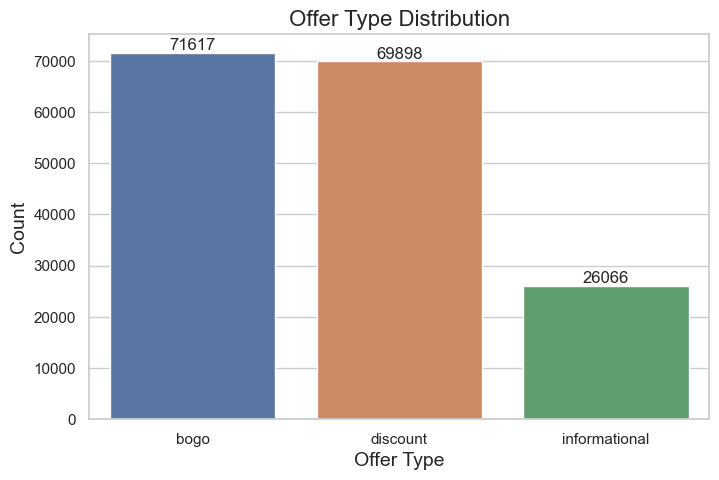

In [42]:
# Examining the distributions of 'offer_type'
offer_type_counts = df['offer_type'].value_counts()
print(offer_type_counts)

# Bar plot of 'offer_type' 
sns.set(style = 'whitegrid')

# Create a bar plot 
plt.figure(figsize= (8,5))
ax = sns.barplot(x = offer_type_counts.index, y = offer_type_counts.values, hue = offer_type_counts.index)

# Titles and labels
plt.title('Offer Type Distribution', fontsize = 16)
plt.xlabel('Offer Type', fontsize = 14)
plt.ylabel('Count', fontsize =14)

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

age_cat
young_adult               19822
early_career              45291
senior                    47023
mid_career                76032
approaching_retirement    84594
Name: count, dtype: int64


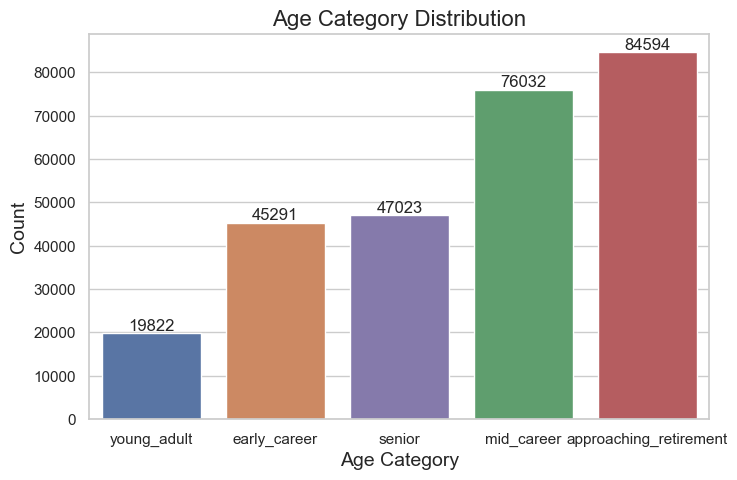

In [45]:
# Examining the distributions of 'age_cat'
age_cat_counts = df['age_cat'].value_counts().sort_values(ascending = True)
print(age_cat_counts)

# Bar plot of 'age_cat' 
sns.set(style = 'whitegrid')

# Create a bar plot 
plt.figure(figsize= (8,5))
ax = sns.barplot(x = age_cat_counts.index, y = age_cat_counts.values, hue = age_cat_counts.index, order=age_cat_counts.index)

# Titles and labels
plt.title('Age Category Distribution', fontsize = 16)
plt.xlabel('Age Category', fontsize = 14)
plt.ylabel('Count', fontsize =14)

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

In [47]:
df.columns


Index(['person', 'event', 'time', 'offer_id', 'amount', 'reward_earned',
       'gender', 'age', 'became_member_on', 'income', 'age_cat',
       'reward_offer', 'channels', 'difficulty', 'duration', 'offer_type',
       'no_channels', 'membership_duration'],
      dtype='object')

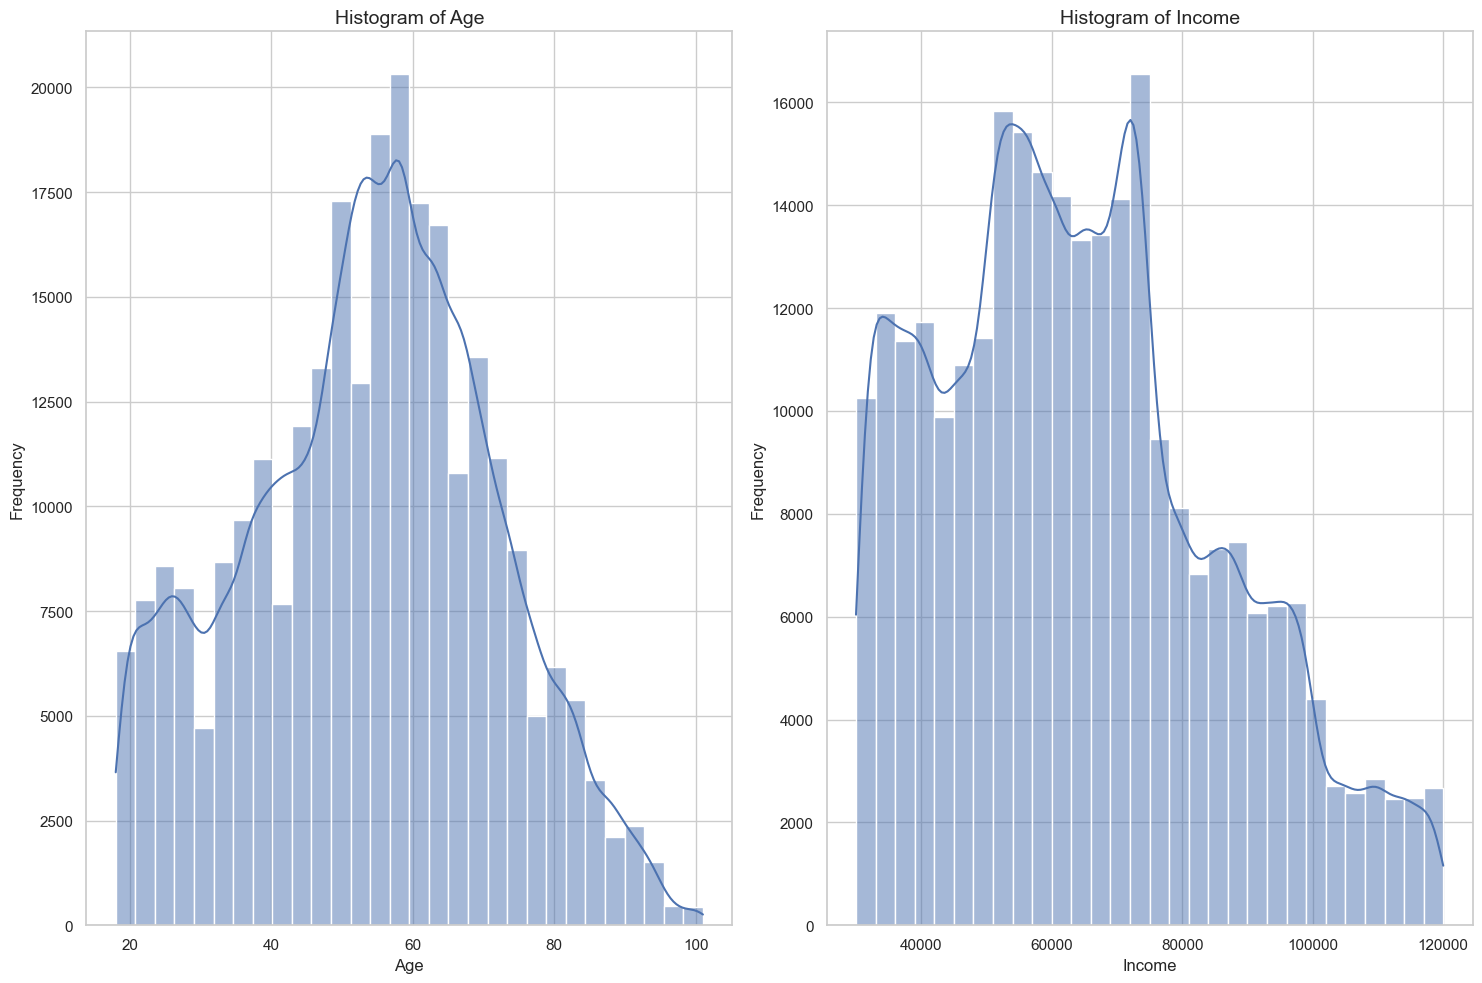

In [49]:
# Examining the distributions of 'age' and 'income'
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# List of numeric columns to plot
numeric_columns = ['age', 'income']

# Loop through each column and plot a histogram
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, 2, i)  # Adjust the grid layout (1 rows, 2 columns)
    sns.histplot(df[column].dropna(), bins=30, kde=True)  # Drop missing values and add KDE
    plt.title(f'Histogram of {column.capitalize()}', fontsize=14)
    plt.xlabel(column.capitalize(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()  # Adjust spacing to fit all plots nicely
plt.show()


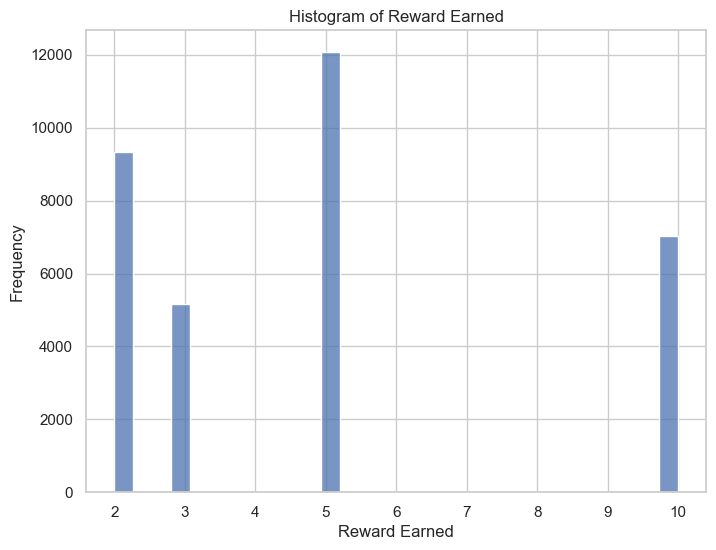

In [51]:
# Plotting histogram for 'reward_earned'
plt.figure(figsize=(8, 6))
sns.histplot(df['reward_earned'].dropna(), bins=30)
plt.title("Histogram of Reward Earned")
plt.xlabel("Reward Earned")
plt.ylabel("Frequency")
plt.show()




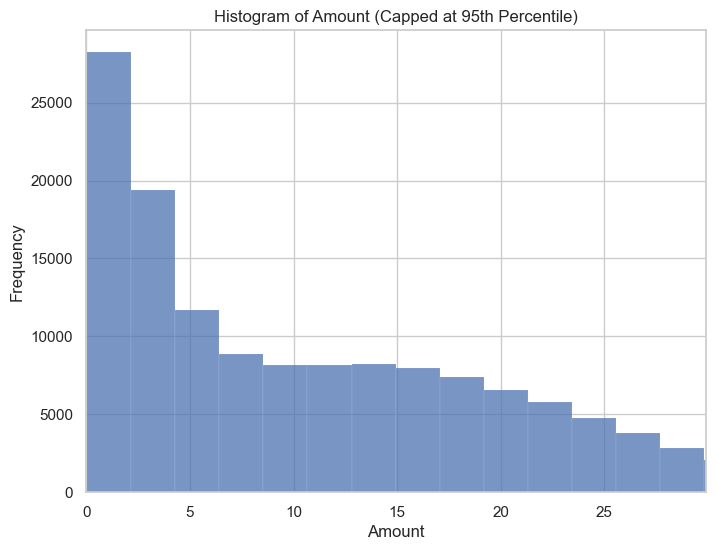

In [63]:
# Calculate the 95th percentile of 'amount' to set as the upper x-limit
upper_limit = df['amount'].quantile(0.95)

# Plotting histogram for 'amount' with capped x-axis
plt.figure(figsize=(8, 6))
sns.histplot(df['amount'].dropna(), bins=500)
plt.title("Histogram of Amount (Capped at 95th Percentile)")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(0, upper_limit)  # Set x-axis limit to the 95th percentile

plt.show()


In [58]:
df['amount'].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

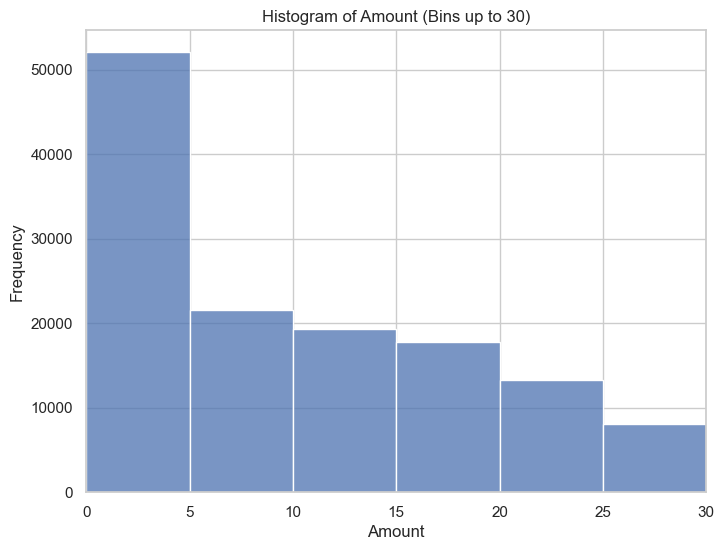

In [67]:
# Specify custom bin edges with the last bin being 30 and above
bin_edges = [0, 5, 10, 15, 20, 25, 30]

# Plot histogram with custom bins and limited x-axis
plt.figure(figsize=(8, 6))
sns.histplot(df['amount'].dropna(), bins=bin_edges)
plt.title("Histogram of Amount (Bins up to 30)")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(0, 30)  # Limit x-axis to focus on range up to 30
plt.show()

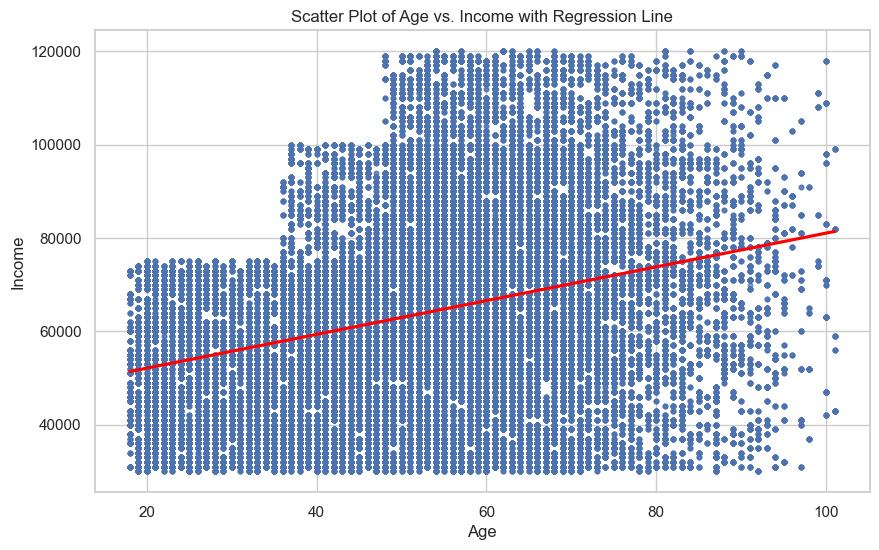

In [71]:
# Scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='age', y='income', scatter_kws={'s':10, 'alpha':0.3}, line_kws={'color': 'red'})
plt.title("Scatter Plot of Age vs. Income with Regression Line")
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

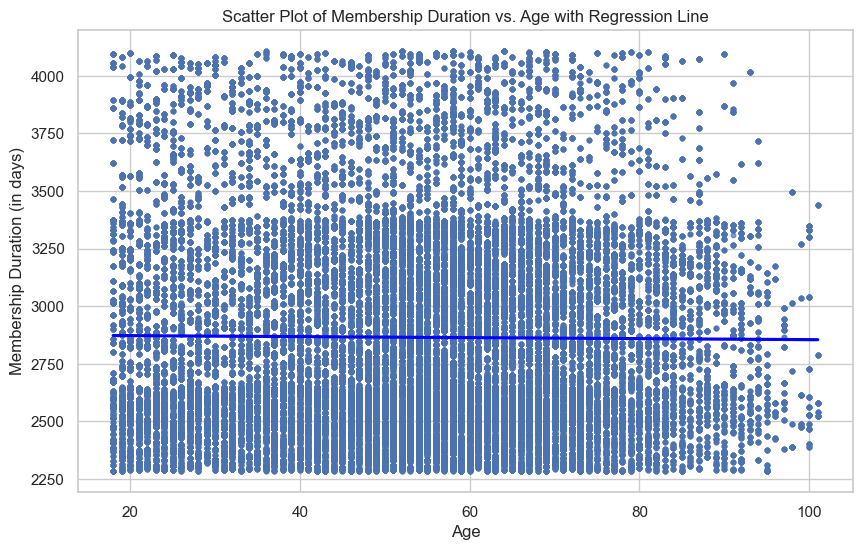

In [72]:
# Scatter plot of Membership Duration vs. Age with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='age', y='membership_duration', scatter_kws={'s':10, 'alpha':0.3}, line_kws={'color': 'blue'})
plt.title("Scatter Plot of Membership Duration vs. Age with Regression Line")
plt.xlabel("Age")
plt.ylabel("Membership Duration (in days)")
plt.show()


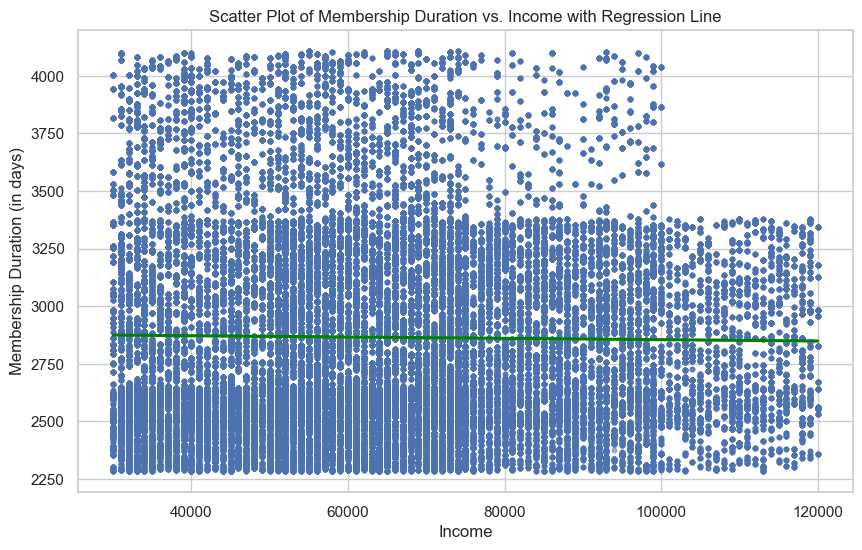

In [73]:
# Scatter plot of Membership Duration vs. Income with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='income', y='membership_duration', scatter_kws={'s':10, 'alpha':0.3}, line_kws={'color': 'green'})
plt.title("Scatter Plot of Membership Duration vs. Income with Regression Line")
plt.xlabel("Income")
plt.ylabel("Membership Duration (in days)")
plt.show()


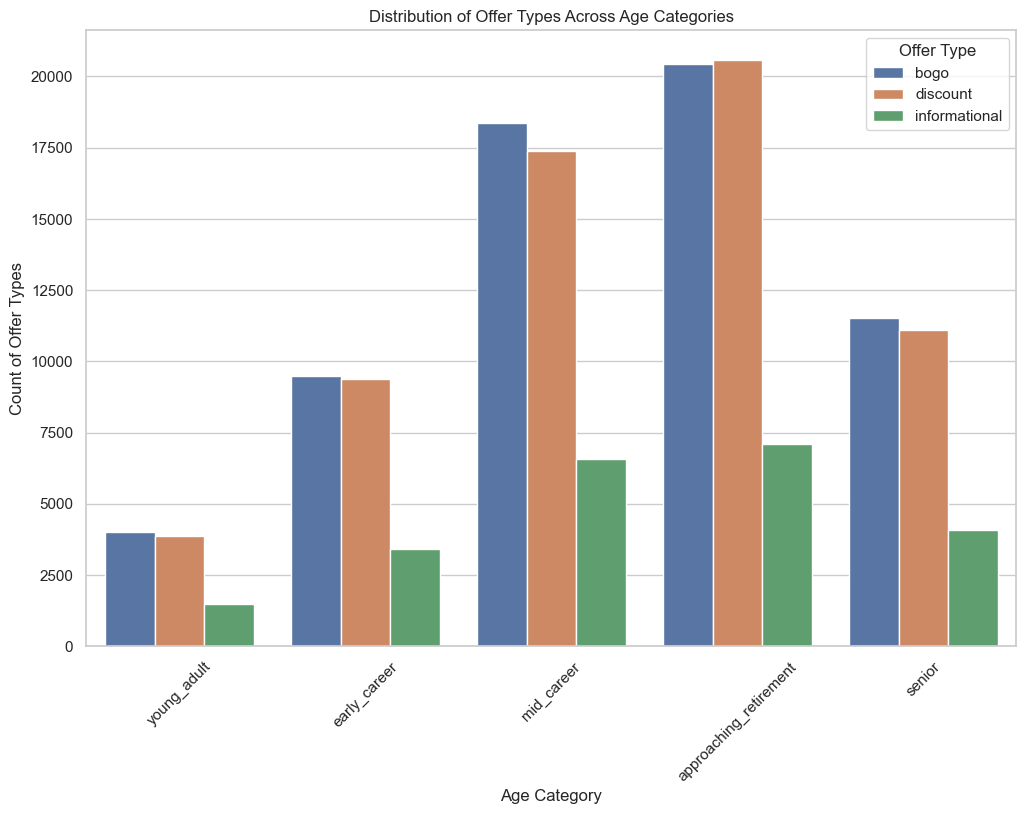

In [77]:
# Set up the bar plot to compare offer_type across different age_cat categories
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='age_cat', hue='offer_type', palette='deep')
plt.title("Distribution of Offer Types Across Age Categories")
plt.xlabel("Age Category")
plt.ylabel("Count of Offer Types")
plt.legend(title="Offer Type")
plt.xticks(rotation=45)
plt.show()


In [79]:
df.info(
    
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   person               306534 non-null  object        
 1   event                306534 non-null  object        
 2   time                 306534 non-null  int64         
 3   offer_id             167581 non-null  object        
 4   amount               138953 non-null  float64       
 5   reward_earned        33579 non-null   float64       
 6   gender               272762 non-null  object        
 7   age                  272762 non-null  float64       
 8   became_member_on     306534 non-null  datetime64[ns]
 9   income               272762 non-null  float64       
 10  age_cat              272762 non-null  category      
 11  reward_offer         167581 non-null  float64       
 12  channels             306534 non-null  object        
 13  difficulty    

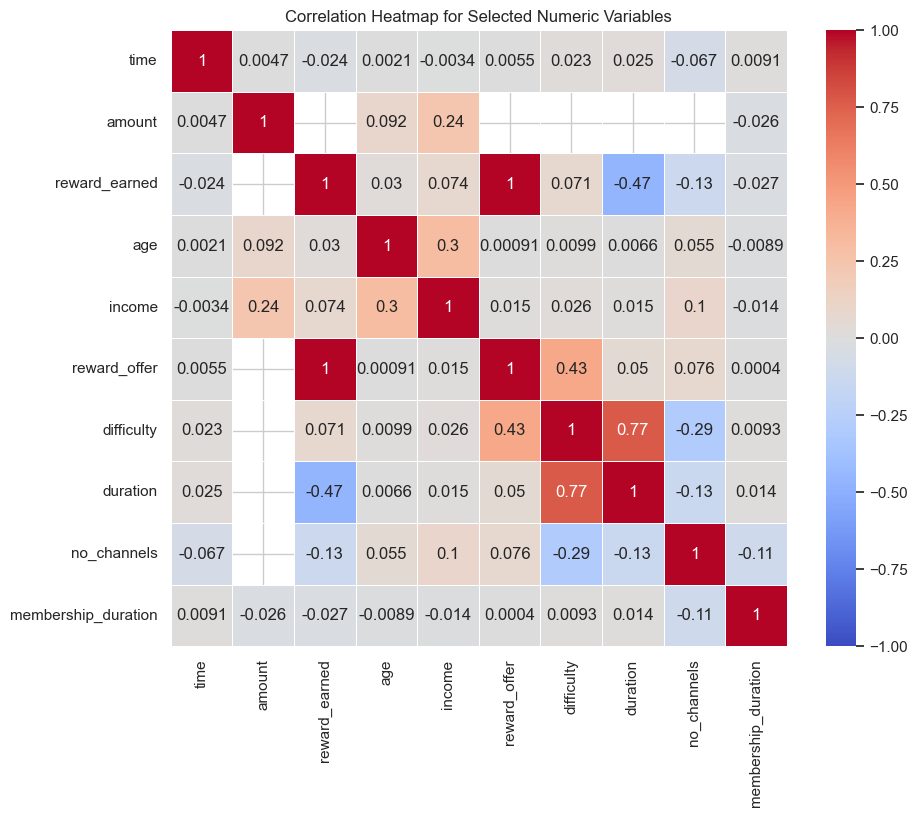

In [80]:
# Select only numeric columns
numeric_columns = ['time', 'amount', 'reward_earned', 'age', 'income', 'reward_offer', 'difficulty', 'duration', 'no_channels', 'membership_duration']

# Calculate the correlation matrix for the selected numeric columns
correlation_matrix = df[numeric_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, linewidths=0.5, vmin=-1, vmax=1)

# Add title
plt.title('Correlation Heatmap for Selected Numeric Variables')
plt.show()



In [83]:
df['time']

0        1970-01-01 00:00:00.000000000
1        1970-01-01 00:00:00.000000000
2        1970-01-01 00:00:00.000000000
3        1970-01-01 00:00:00.000000000
4        1970-01-01 00:00:00.000000000
                      ...             
306529   1970-01-01 00:00:00.000000714
306530   1970-01-01 00:00:00.000000714
306531   1970-01-01 00:00:00.000000714
306532   1970-01-01 00:00:00.000000714
306533   1970-01-01 00:00:00.000000714
Name: time, Length: 306534, dtype: datetime64[ns]

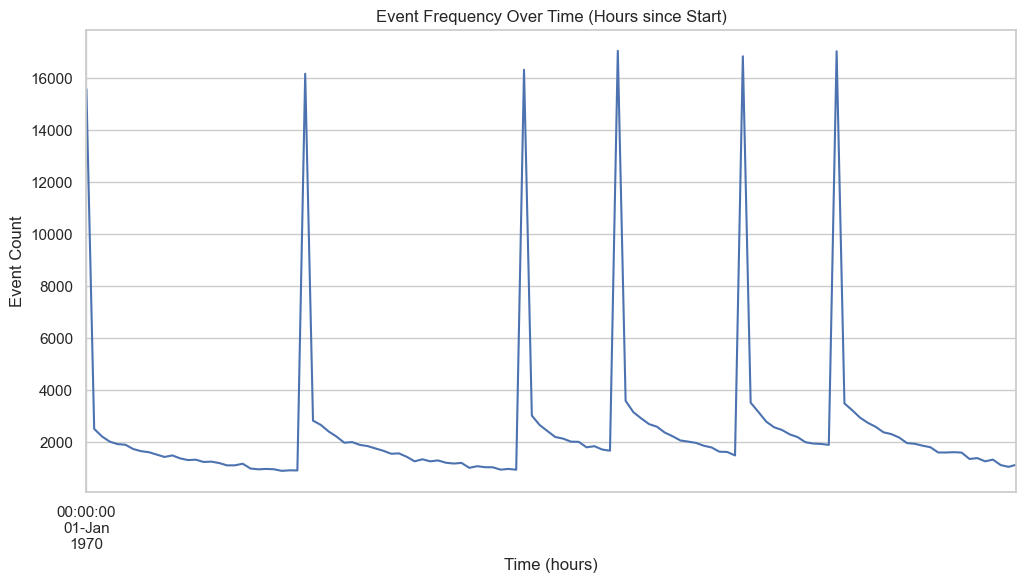

In [85]:
# Group data by 'time' (in hours) and count occurrences
time_counts = df.groupby('time').size()

# Plot event frequency over time
plt.figure(figsize=(12, 6))
time_counts.plot(kind='line')
plt.title("Event Frequency Over Time (Hours since Start)")
plt.xlabel("Time (hours)")
plt.ylabel("Event Count")
plt.show()

